https://www.kaggle.com/datasets/prathamtripathi/drug-classification класифікація ліків

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

from os import listdir
from PIL import Image as PImage

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from collections import Counter

from wordcloud import WordCloud

In [2]:
def make_std(data, y_name):
    data_std = (data - data.mean())/data.std()
    data_std[y_name] = data[y_name]
    return data_std
def pre_processing(data, processed_columns, dictionary_pre_processing):
    for column in processed_columns: #проходимо по всім стовбчикам що не є числами
        if column in dictionary_pre_processing: #якщо є в dictionary_pre_processing використовуємо його
            data[column] = transform_column_and_check(data[column], dictionary_pre_processing[column])
        else:
            dictionary = {} #якщо нема, то починаємо з пустого
            data[column] = transform_column_and_check(data[column], dictionary)
            dictionary_pre_processing[column] = dictionary #оновлюю словник (може бути використано далі для перетворення)
    data[processed_columns] = data[processed_columns].apply(pd.to_numeric) #перетворюємо на число в самому dataframe
    

In [3]:
def transform_column_and_check(column, dictionary): #для перетворення текстових значень
    column = column.apply(check_key_or_add, args = (dictionary,)) #використовуючи словник замінюємо текстові значення
    return column
def check_key_or_add(item, dictionary):
    if item not in dictionary: dictionary[item] = len(dictionary) 
        #додаємо до dictionary нове текстове значення якщо воно не існує, пара — довжтна dictionary
        #необхідно щоб dictionary виглядало як {text:0, text1:1, text2:2 ... text_n: n}
    return dictionary[item] #повертаю числове значення

In [4]:
data_drug=pd.read_csv("drug200.csv") #Читаємо всю інформацію
data_drug.keys()

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [5]:
BP = {
    'LOW':0, 'NORMAL':1, 'HIGH':2
} #Словник для тиску крові
Cholesterol = {'LOW':0, 'NORMAL':1, 'HIGH':2} #Словник для холестирину
Sex = {'M': 0, 'F': 1} #Словник для статті
Drug = {'drugA': 0, 'drugB': 1, "drugC": 2, "drugX": 3, "DrugY": 4} #Словник для ліків
replace_dict_drug = {"BP":BP, "Cholesterol":Cholesterol, "Sex": Sex, 
                "Drug": Drug} #словник словників
pre_processing(data_drug, ["BP", "Cholesterol", "Sex", "Drug"], replace_dict_drug) #Замінити текст на числові значення


X = data_drug[data_drug.columns[:-1]] #Ігноруючи ліки
y = data_drug["Drug"] #шукаємо які ліки виписати

In [6]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [7]:
pca = PCA()
X_pca = pca.fit_transform(X_std)

In [8]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

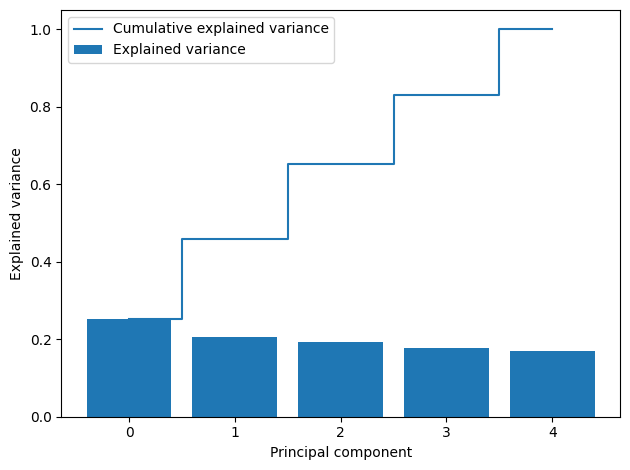

In [9]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

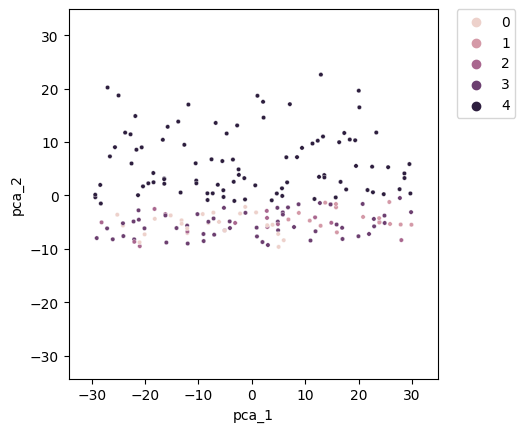

In [10]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-5, pca_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

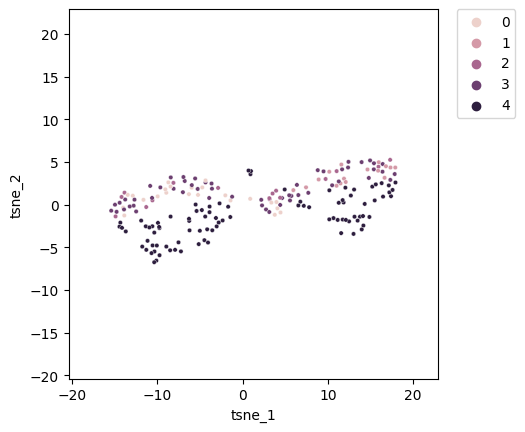

In [11]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Public Domain, https://commons.wikimedia.org/w/index.php?curid=157164

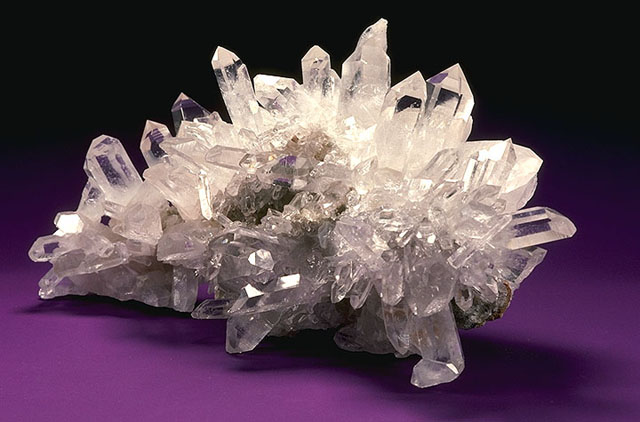

In [13]:
crystal = PImage.open("crystal.jpg")
crystal

In [14]:
crystal = np.array(crystal, dtype=np.float64) / 255
w, h, d = tuple(crystal.shape)

In [15]:
def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)

def quant_img(image, depth = 64):
    w, h, d = tuple(image.shape)
    image_array = np.reshape(image, (w*h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=depth, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    return kmeans, labels

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


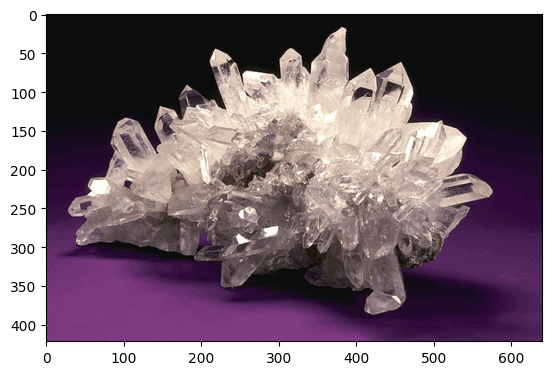

In [16]:
kmeans_64, labels_64 = quant_img(crystal)
plt.imshow(recreate_image(kmeans_64.cluster_centers_, labels_64, w, h))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


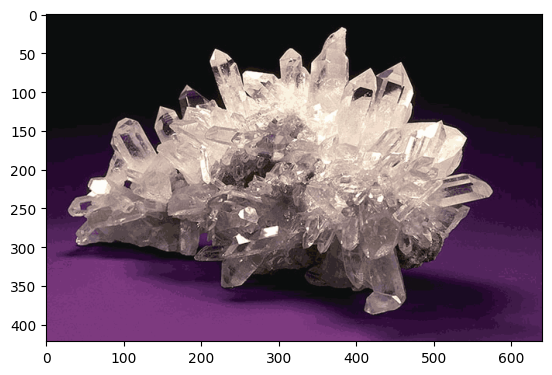

In [17]:
kmeans_32, labels_32 = quant_img(crystal, 32)
plt.imshow(recreate_image(kmeans_32.cluster_centers_, labels_32, w, h))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


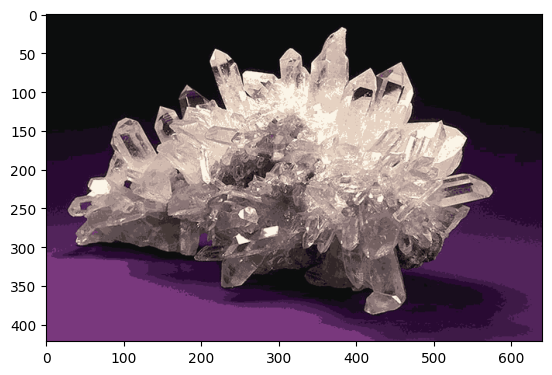

In [18]:
kmeans_16, labels_16 = quant_img(crystal, 16)
plt.imshow(recreate_image(kmeans_16.cluster_centers_, labels_16, w, h))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


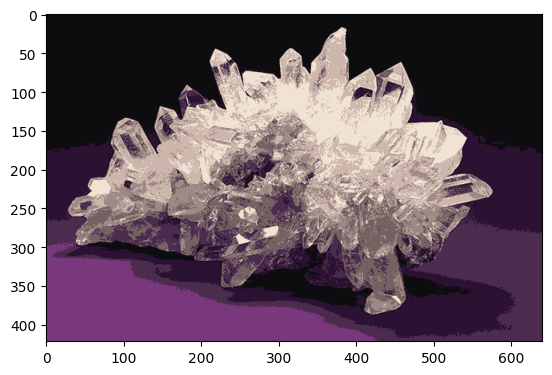

In [19]:
kmeans_8, labels_8 = quant_img(crystal, 8)
plt.imshow(recreate_image(kmeans_8.cluster_centers_, labels_8, w, h))

In [20]:
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [21]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
#nltk.download('stopwords')
#nltk.download('punkt')
stop_words = stopwords.words('english')

Набір даних легальних текстів для класифікації https://www.kaggle.com/datasets/amohankumar/legal-text-classification-dataset

In [22]:
legal_text=pd.read_csv("legal_text_classification.csv")
legal_text.keys()
counter = Counter(legal_text["case_outcome"])
print(counter)

Counter({'cited': 12219, 'referred to': 4384, 'applied': 2448, 'followed': 2256, 'considered': 1712, 'discussed': 1024, 'distinguished': 608, 'related': 113, 'affirmed': 113, 'approved': 108})


In [23]:
counter = Counter(legal_text["case_outcome"])
print(counter)

print(Counter(legal_text[legal_text['case_text'].isna()]['case_text']))
print(Counter(legal_text[legal_text['case_outcome'].isna()]['case_outcome']))

Counter({'cited': 12219, 'referred to': 4384, 'applied': 2448, 'followed': 2256, 'considered': 1712, 'discussed': 1024, 'distinguished': 608, 'related': 113, 'affirmed': 113, 'approved': 108})
Counter({nan: 176})
Counter()


In [24]:
legal_text = legal_text[legal_text['case_text'].notnull()] #Приберу всі випадки коли текст порожній
print(Counter(legal_text[legal_text['case_text'].isna()]['case_text']))

Counter()


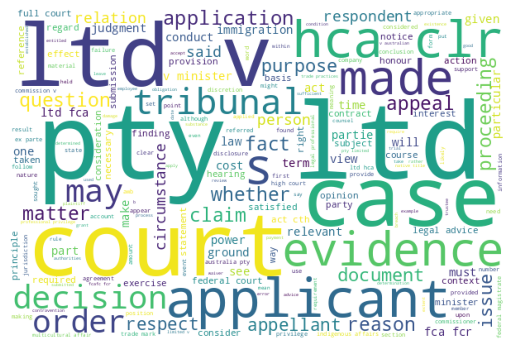

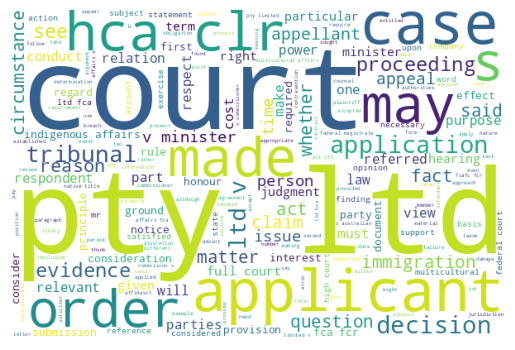

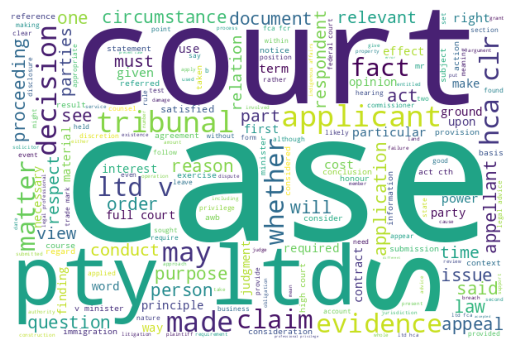

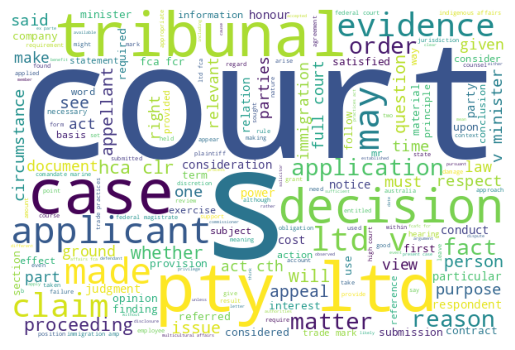

In [25]:
def visualize(label, df):
    text = ''
    for msg in df[df['case_outcome'] == label]['case_text']:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

visualize('cited', legal_text)
visualize('referred to', legal_text)

visualize('applied', legal_text)
visualize('followed', legal_text)

In [26]:
x_legal = legal_text['case_text']
y_legal = legal_text[['case_outcome']]

case_outcome = {
    'cited':0, 'referred to':1, 'applied':2, 'followed': 3, 'considered': 4, 'discussed': 5, 'distinguished': 6, 'related': 7, 'affirmed': 8, 'approved': 9
}
pre_processing(y_legal, ["case_outcome"], {"case_outcome" : case_outcome}) #Замінити текст на числові значення
y_legal = y_legal['case_outcome']
counter = Counter(y_legal)
print(counter)

Counter({0: 12110, 1: 4363, 2: 2438, 3: 2252, 4: 1699, 5: 1018, 6: 603, 7: 112, 9: 108, 8: 106})


/var/folders/gk/n5z332z96y77s_cf349_684w0000gn/T/ipykernel_1143/2844964558.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = transform_column_and_check(data[column], dictionary_pre_processing[column])
/var/folders/gk/n5z332z96y77s_cf349_684w0000gn/T/ipykernel_1143/2844964558.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[processed_columns] = data[processed_columns].apply(pd.to_numeric) #перетворюємо на число в самому dataframe


In [27]:
x_legal = x_legal.apply(clean_text)

In [28]:
x_legal[1]

'general principles governing exercise discretion award indemnity costs rejection unsuccessful party called calderbank letter set judgment full court black v lipovac fca alr summary principles mere refusal calderbank offer warrant order indemnity costs connection may noted jessup j dais studio pty ltd v bullet creative pty ltd fca said rejection offer ground claim indemnity costs must reason circumstance offer happened comply calderbank principle obtain order indemnity costs offeror must show refusal accept unreasonable reasonableness conduct offeree viewed light circumstances existed offer rejected '

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_legal, y_legal, test_size=0.20)
print(X_train.shape, y_train.shape)

(19847,) (19847,)


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
vectorizer = CountVectorizer(stop_words=stop_words)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [32]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.47      0.58      2434
           1       0.43      0.58      0.49       912
           2       0.21      0.24      0.22       461
           3       0.26      0.42      0.32       435
           4       0.29      0.17      0.21       313
           5       0.25      0.37      0.30       213
           6       0.19      0.41      0.26       119
           7       0.16      0.50      0.24        24
           8       0.24      0.74      0.36        27
           9       0.06      0.12      0.08        24

    accuracy                           0.44      4962
   macro avg       0.28      0.40      0.31      4962
weighted avg       0.52      0.44      0.46      4962



Text(0.5, 23.52222222222222, 'Predicted')

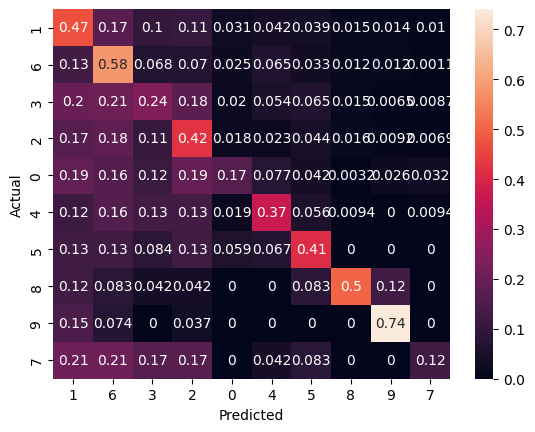

In [34]:
labels = list(Counter(y_test).keys())
cm2 = confusion_matrix(y_test, y_pred)
cmn = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot = True, xticklabels=labels, yticklabels=labels) #намалювати теплову карту
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [35]:
tfid_vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train_transformed_1 = tfid_vectorizer.fit_transform(X_train)
X_test_transformed_1 = tfid_vectorizer.transform(X_test)

In [36]:
clf_1 = MultinomialNB(alpha=0.1)
clf_1.fit(X_train_transformed_1, y_train)
y_pred_1 = clf_1.predict(X_test_transformed_1)

In [37]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.55      0.95      0.69      2434
           1       0.68      0.32      0.43       912
           2       0.38      0.09      0.15       461
           3       0.60      0.12      0.20       435
           4       0.41      0.09      0.14       313
           5       0.39      0.07      0.11       213
           6       0.90      0.08      0.14       119
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        24

    accuracy                           0.55      4962
   macro avg       0.39      0.17      0.19      4962
weighted avg       0.54      0.55      0.47      4962



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Text(0.5, 23.52222222222222, 'Predicted')

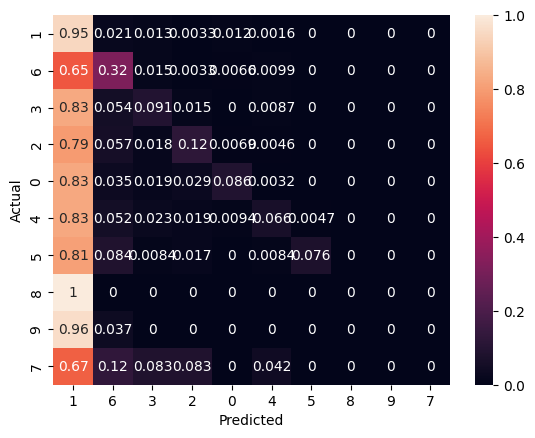

In [38]:
labels = list(Counter(y_test).keys())
cm2_1 = confusion_matrix(y_test, y_pred_1)
cmn_1 = cm2_1.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn_1, annot = True, xticklabels=labels, yticklabels=labels) #намалювати теплову карту
plt.ylabel('Actual')
plt.xlabel('Predicted')